In [106]:
#
# Visualization of data statistic
# 
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplot
from matplotlib.figure import Figure 
#from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors as mcolors
import colorsys
import seaborn as sbn

# Data frame: 
#   data: data in dictionary with labels X: 'xl', Y: 'yl';
#         data[{xl, yl}]: matrix of size #samples * #variables
#   tag:  dictionary of X & Y variable names (optional), shown as labels of data in the output
class Dataframe:
    def __init__(self, data, tag = None, xl='X', yl='Y'):
        self.nx = len(data[xl][0])
        self.ndata = len(data[xl])
        dy = data[yl]
        try:
            self.ny = len(data[yl][0])
        except:
            self.ny = 1
            dy = [[data[yl][i]] for i in range(len(data[yl]))]
        print("Dataframe: ndata / nx / ny is {:d} {:d} {:d}\n".format(self.ndata, self.nx, self.ny))
        if tag is None:
            xlist = list([xl+'-'+str(i) for i in range(self.nx)])
            ylist = list([yl+'-'+str(i) for i in range(self.ny)])
        else:
            xlist = list(tag[xl])
            ylist = list(tag[yl])
        self.data = pd.DataFrame(np.array(data[xl]).reshape(self.ndata, self.nx), 
                                 columns=xlist)
        print(len(dy))
        self.clist = xlist
        self.clist.extend(ylist)
        dy = np.array(dy).T
        for i in range(self.ny):
            #print(list(dy[0:len(dy)][i]))
            self.data.insert(self.nx+i, ylist[i], list(dy[i]))
        self.block = 1
        self.colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
        self.colorlist = [ name for name, color in self.colors.items()]
        
    # Calculate autocorrelations
    #   Return the block size, the autocorrelation 
    #   tol: maximum autocorrelation
    def autocorr(self, tol):
        assert(1.>tol>0.)
        at = 1.0
        block = 0
        while at > tol:
            if block > 0:
                block += int((at-tol)*5+1)
            else:
                block = 1
            at = 0.
            for i in range(self.nx):
                atn = pd.Series(self.data.iloc[:,i].to_dict()).autocorr(block)
                if atn > at: 
                    at = atn
        return block, at 
    
    # Block data with block size 'blk'                             
    def blockdata(self, blk):
        if blk > 1:
            self.data = pd.DataFrame(np.array([[self.data.iloc[i:i+blk,j].mean() for j in range(self.nx+self.ny)]
                                             for i in range(0, self.ndata, blk)]).reshape(int(self.ndata/blk), self.nx+self.ny), 
                                columns=self.clist)
        self.block = blk
        return
    
    # Plot histgrams
    #   crange: range of variables using pure digital position location in the data table
    #   out: output filename, None for no store of the output
    def hist(self, crange = None, out = None):
        try:
            cmn = crange[0]
        except:
            cmn = 0
        if cmn is None:
            cmn = 0
        try:
            cmx = crange[1]
        except:
            cmx = self.nx+self.ny
        if cmx is None:
            cmx = self.nx+self.ny
        if out is not None:
            #Figure()
            #canves = FigureCanvasTkAgg(fig)
            #fig.set_canvas(canves)
            sfx = '.pdf'
            n = 1
            while True:
                try:
                    pf = open(out+'.hist'+sfx, 'r')
                except:
                    break
                pf.close()
                sfx = '.'+str(n)+'.pdf'
                n+=1
            #pp = PdfPages(out+'.hist'+sfx)
        fig, ax = mplot.subplots(nrows=int((cmx-cmn+9)/10))
        n = 0
        for i in range(cmn, cmx, 10):
            #if out is not None:
             #   fig = mplot.figure()
            j=i
            if i+10<cmx:
                j=i+10
            else:
                j=cmx
            ax[n] = self.data.iloc[:,i:j-1].plot.hist(subplots=True, bins=int(self.ndata/4), title='Data(X Y) histgram')
            mplot.show()
            #if out is not None:
                #fig.add_subplot(n, 1, n)
             #   pp.savefig(fig)
            n += 1 
        if out is not None:   
            fig.savefig(out+'.hist'+sfx, format = 'pdf')
        return
      
    # Density plot
    #   data: pandas.DataFrame; None for using stored data
    def density(self, crange = None, out = None, data=None):
        try:
            cmn = crange[0]
        except:
            cmn = 0
        if cmn is None:
            cmn = 0
        try:
            cmx = crange[1]
        except:
            if data is None:
                cmx = self.nx+self.ny
            else:
                cmx = len(data.columns)
        if cmx is None:
            if data is None:
                cmx = self.nx+self.ny
            else:
                cmx = len(data.columns)
        if data is None:
            data = self.data
        if False:#out is not None:
            fig = Figure()
            canves = FigureCanvasTkAgg(fig)
            fig.set_canvas(canves)
        n = 0
        fig, ax = mplot.subplots(nrows=int((cmx-cmn+9)/10))
        for i in range(cmn, cmx, 10):
            j=i
            if i+10<cmx:
                j=i+10
            else:
                j=cmx
            ax[n] = data.iloc[:,i:j-1].plot.density()
            mplot.show()
            if False:# out is not None:
                fig.add_subplot(n, 1, n)
            n += 1 
        if out is not None:
            sfx = '.pdf'
            n = 1
            while True:
                try:
                    pf = open(out+'.kde'+sfx, 'r')
                except:
                    break
                pf.close()
                sfx = '.'+str(n)+'.pdf'
                n+=1               
            fig.savefig(out+'.kde'+sfx, format = 'pdf')
        return
    
    # Box plot 
    #   title for the plot title
    #   data: pandas.DataFrame
    #   dform: 'pdf' for plotting according to p, z, (T)
    def boxplot(self, crange = None, data = None, title=None, out = None, dform = 'pdf'):
        def make_color(cols, pred):
            def lighten_color(color, amount=0.5):
                """
                Lightens the given color by multiplying (1-luminosity) by the given amount.
                Input can be matplotlib color string, hex string, or RGB tuple.

                Examples:
                >> lighten_color('g', 0.3)
                >> lighten_color('#F034A3', 0.6)
                >> lighten_color((.3,.55,.1), 0.5)
                """
                try:
                    c = mcolors.cnames[color]
                except:
                    c = color
                c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
                return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
            colors = mcolors.cnames #dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
            colorlist = [ name for name, color in colors.items()]
            tg={}
            for col in cols:
                if pred and ('pred' not in col):
                    continue
                if ('pred' in col) and (pred is False):
                    continue
                if col.split('+t+')[0] not in tg:
                    tg[col.split('+t+')[0]] = None
            i=0
            for col in tg:
                p=int(col.split('+')[0])
                z=col.split('+')[1]
                #t=int(col.split('+')[-2])
                #ri=col.split('+')[-1]
                if 'T' in col:
                    T = col.split('+')[-1]
                else:
                    T = str(None)
                clr = colorlist[i]
                if pred:
                    clr = lighten_color(clr, 0.5)
                tg[col] = clr
                i += 1
            return tg    
        #self.dform = dform
        try:
            cmn = int(crange[0])
        except:
            cmn = 0
        try:
            cmx = int(crange[1])
        except:
            if data is None:
                cmx = self.nx+self.ny
            else:
                cmx = len(data.columns)
        if data is None:
            data = self.data
        if False:#if out is not None:
            fig = Figure()
            canves = FigureCanvasTkAgg(fig)
            fig.set_canvas(canves) 
        n = 0
        if dform == 'pdf':
            #self.NA = str(None)
            if out is not None:
                sfx = '.pdf'
                m = 1
                while True:
                    try:
                        pf = open(out+'.box'+sfx, 'r')
                    except:
                        break
                    pf.close()
                    sfx = '.'+str(m)+'.pdf'
                    m+=1
                pltname = out+'.box'+sfx
                fig = mplot.figure()
            clrpred = make_color(data.columns, True)
            clr = make_color(data.columns, False)
            for col in clr:
                cln = []
                tl = []
                for c in data.columns:
                    if ('pred' not in c) and (col+'+t+' in c):
                        cln.append(c)
                        tl.append(int(c.split('+')[-2]))
                data.loc[:, cln].plot.box(title=title, colormap=clr[col], subplots=True, 
                                          sharex=True, sharey=True, xticks=tl)
                mplot.show()
                if out is not None:
                    fig.add_subplot()
                del cln
                del tl
            for col in clrpred:
                cln = []
                tl = []
                for c in data.columns:
                    if ('pred' in c) and (col+'+t+' in c):
                        cln.append(c)
                        tl.append(int(c.split('+')[-2]))
                data.loc[:, cln].plot.box(title=title, colormap=clrpred[col], subplots=True, 
                                          sharex=True, sharey=True, xticks=tl)
                mplot.show()
                if out is not None:
                    fig.add_subplot()
                del cln
                del tl
            if out is not None:
                fig.savefig(pltname, format='pdf')
            return   
        for i in range(cmn, cmx, 10):
            j=i+10
            if j>cmx:
                j=cmx
            data.iloc[:,i:j].plot.box(title=title)
            mplot.show()
            if out is not None:
                sfx = '.pdf'
                m = 1
                while True:
                    try:
                        pf = open(out+'.box'+sfx, 'r')
                    except:
                        break
                    pf.close()
                    sfx = '.'+str(m)+'.pdf'
                    m+=1               
                mplot.savefig(out+'.box'+sfx, format = 'pdf')
                #fig.add_subplot(n, 1, n)
            n += 1 
        if False:#if out is not None:
            sfx = '.pdf'
            n = 1
            while True:
                try:
                    pf = open(out+'.box'+sfx, 'r')
                except:
                    break
                pf.close()
                sfx = '.'+str(n)+'.pdf'
                n+=1               
            fig.savefig(out+'.box'+sfx, format = 'pdf')
        return
    
    # Errorbar plot; default data format 'pdf':
    #   data: dictionary of 'x', 'y', ('xerr', 'yerr')
    #         each item is the dictionary of data features in the arraylike object
    #   shape: specify plot layout: 
    #          'None' (default): all z's and p's in a column, all T's in same subplot
    #          'T': all z's in a row, all p's in a column, all T's in same subplot
    #          'z': all z's in same subplot, all T's in a row
    #          'p': all p's in same subplot, all T's in a column
    def errbarplot(self, crange = None, data = None, shape = None, title=None, clrid = None, out = None, panel = None, dform = 'pdf'):
        #print('color key is {:}'.format(clrid))
        if clrid is not None:
            colorlist = [ name for name, color in mcolors.cnames.items()]
        def lighten_color(color, amount=1):
            """
            Lightens the given color by multiplying (1-luminosity) by the given amount.
            Input can be matplotlib color string, hex string, or RGB tuple.

            Examples:
            >> lighten_color('g', 0.3)
            >> lighten_color('#F034A3', 0.6)
            >> lighten_color((.3,.55,.1), 0.5)
            """
            try:
                c = mcolors.cnames[color]
            except:
                c = color
            c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
            if amount > 0:
                return colorsys.hls_to_rgb(c[0], .7, c[2])  
            elif amount == 0:
                return colorsys.hls_to_rgb(c[0], .5, c[2])
            else:
                return colorsys.hls_to_rgb(c[0], .3, c[2])
            if False: #if amount >= 0.:
                return colorsys.hls_to_rgb(c[0], 1. - amount * (1. - c[1]), c[2])  
            #else:
                return colorsys.hls_to_rgb(c[0], (1. + amount) * c[1], c[2])
        def set_limit(data, derr, grpid=None):
            llim = {}
            ulim = {}
            keylist = {}
            for key in data:
                d = np.array(data[key])[~np.isnan(data[key])].tolist()
                err = np.array(derr[key])[~np.isnan(derr[key])]
                emax = err.max()
                emean = err.mean()
                #std = { 'o': np.array(d['o']).std(), 'p': np.array(d['p']).std()}
                i = 1
                while len(d)>3:        
                    pmm = np.array(d).min()
                    if np.array(d).min() + np.array(d).max() > 2.*np.array(d).mean():
                        pmm = np.array(d).max()
                    d1 = d.copy()
                    print("d1 = {:} , remove {:}".format(d1, pmm))
                    d1.remove(pmm)
                    ad = np.array(d)
                    ad1 = np.array(d1)
                    #print(np.array(d).mean() - np.array(d1).mean(), emax, np.array(d).std(), np.array(d1).std())
                    if 0<abs(ad.mean()-ad1.mean()) - abs(np.quantile(ad,.5)-np.quantile(ad1,.5))<abs(ad.std()-ad1.std()): #max(emax, min(np.array(d1).std(), abs(np.array(d).std()-np.array(d1).std()))): #1.0-i*q >= qmax:
                        #print("Number of points {:}".format((ad[pmm-5.*err.mean()<ad])[ad[pmm-5.*err.mean()<ad]<pmm+5.*err.mean()].shape))
                        if (ad[pmm-10.*emean<ad])[ad[pmm-10.*emean<ad]<pmm+10.*emean].shape[0] == 1:#ad1.shape[0]:
                            print("removing {:}".format(pmm))
                            d.remove(pmm)
                        else:
                            del d1
                            break
                    else:
                        del d1
                        break
                    #sigma = np.quantile(np.array(d), (i+1.)*q) - np.quantile(np.array(d), (i-1.)*q)
                    #if sigma <= emax*bd:
                     #   break
                    i += 1.0
                    del d1
                err = err.tolist()
                err.sort()
                emdn = err[int(len(err)/2)]
                while (len(err) > 4) and (err[-1] >= 5.*err[int(len(err)/2)]):
                    err.pop(-1)
                emax = err[-1]
                kk = ('+'.join(key.split('+')[:-1])).split('+T+')
                if grpid == 'p':
                    kl = kk[0].split('+')[0]
                    if len(kk[0].split('+')) > 2:
                        kl = kl+'+'+(kk[0].split('+')[2])
                else: 
                    if grpid is None:
                        kl = kk[0]
                    else:
                        kl = '+'.join(kk[0].split('+')[:2])                 
                if False:#else:
                    kk = []
                    i=0
                    for k in key.split('+'):
                        if str(i) not in sl:
                            kk.append(k)
                        i += 1
                    kl = '+'.join(kk)
                    keylist[key] = kl
                    del kk
                keylist[key] = kl
                if kl in llim:#if i > 1.0:
                    llim[kl] = min(np.array(d).min()-1.5*emax, llim[kl])
                else:
                    llim[kl] = np.array(d).min()-1.5*emax
                if kl in ulim:
                    ulim[kl] = max(np.array(d).max()+1.5*emax, ulim[kl])
                else:
                    ulim[kl] = np.array(d).max()+1.5*emax
            if False:    
                #d = np.array(d)
                err = np.array(err)
                #dmax = d.max()
                #dmin = d.min()
                emax = err.max()
                std = { 'o': np.array(d['o']).std(), 'p': np.array(d['p']).std()}
                if False:#if std < emax:
                    return None, None
                sigma = 0.
                llim = None
                ulim = None
                i = 1
                while True:        
                    pmm = np.array(d['o']).min()
                    if np.array(d['o']).min() + np.array(d['o']).max() > 2.*np.array(d['o']).mean():
                        pmm = np.array(d['o']).max()
                    d1 = d['o'].copy()
                    #print("d1 = {:} , remove {:}".format(d1, pmm))
                    d1.remove(pmm)
                    #print(np.array(d['o']).mean() - np.array(d1).mean(), emax, np.array(d['o']).std(), np.array(d1).std())
                    if abs(np.array(d['o']).mean() - np.array(d1).mean()) < max(emax, np.array(d1).std()): #1.0-i*q >= qmax:
                        break
                    print("removing {:}".format(pmm))
                    d['o'].remove(pmm)
                    #sigma = np.quantile(np.array(d), (i+1.)*q) - np.quantile(np.array(d), (i-1.)*q)
                    #if sigma <= emax*bd:
                     #   break
                    i += 1.0
                del d1
                if True:#if i > 1.0:
                    llim = np.array(d['o']).min()-2.*emax
                    ulim = np.array(d['o']).max()+2.*emax
            #print(llim, ulim)
            return llim, ulim, keylist
        try:
            cmn = int(crange[0])
        except:
            cmn = 0
        try:
            cmx = int(crange[1])
        except:
            if data is None:
                cmx = self.nx+self.ny
            else:
                cmx = len(data['x'].items())
        if data is None:
            data = self.data   
        if dform == 'pdf':
            pd_offset = 0.2
            #self.NA = str(None)
            scl = 1
            if 'BCyerr' in data:
                scl = 2
            if out is not None:
                sfx = '.pdf'
                m = 1
                while True:
                    try:
                        pf = open(out+'.errbar'+sfx, 'r')
                    except:
                        break
                    pf.close()
                    sfx = '.'+str(m)+'.pdf'
                    m+=1
                pltname = out+'.errbar'+sfx
                #fig = mplot.figure()
            zl=[]
            pl=[]
            Tl=[]
            ol = []
            for tg in data['x']:
                #pfix = 1
                #spfix = len(tg.split('+'))-1
                try:
                    o,p,z,dummy,T,pred=tg.split('+')
                    o = '('+o+')'
                except:
                    try:
                        o,p,z,pred=tg.split('+')
                        o = '('+o+')'
                    except:
                        p,z,pred=tg.split('+')
                        o=''
                        #pfix = 0
                    T=str(None)
                if o not in ol:
                    ol.append(o)
                if z not in zl:
                    #zl[z] = len(zl)
                    zl.append(z)
                if p not in pl:
                    #pl[p] = len(pl)
                    pl.append(p)
                if T not in Tl:
                    #Tl[T] = len(Tl)
                    Tl.append(T)
            zl.sort()
            pl.sort()
            Tl.sort()
            od = {}
            zd = {}
            pd = {}
            Td = {}
            #grpid = None
            for i in range(len(ol)):
                od[ol[i]] = i
            for i in range(len(zl)):
                zd[zl[i]] = i
            for i in range(len(pl)):
                pd[pl[i]] = i
            for i in range(len(Tl)):
                Td[Tl[i]] = i
            if shape == 'p':
                row = len(zl)*len(ol)*scl
                col = len(Tl)
                #grpid = str(pfix)+str(pfix+3)+str(spfix)
                #posit = lambda: p,z,T(if(z==str(None) tl='spectrum'; return Td[T],zd[z])
                def posit(o,p,z,T):
                    if z==str(None):
                        tl = 'Spectrum {:}'.format(o)
                    elif T == str(None):
                        tl = 'DA {:} z={:}'.format(o,z)
                    else:
                        tl = 'PDF {:} z={:} T={:}'.format(o,z,T)
                    return Td[T], scl*(od[o]*len(zl)+zd[z]), tl, Td[T], scl*(od[o]*len(zl)+zd[z]+1)-1
            elif shape == 'z':
                row = len(pl)*len(ol)*scl
                col = len(Tl)
                #grpid = str(pfix+1)+str(pfix+3)+str(spfix)
                #posit = lambda: p,z,T(return pd[p],Td[T])
                def posit(o,p,z,T):
                    if z==str(None):
                        tl = 'Spectrum {:} p={:}'.format(o,p)
                    elif T == str(None):
                        tl = 'DA {:} p={:}'.format(o,p)
                    else:
                        tl = 'PDF {:} p={:} T={:}'.format(o,p,T)
                    return Td[T], scl*(od[o]*len(pl)+pd[p]), tl, Td[T], scl*(od[o]*len(pl)+pd[p]+1)-1
            elif shape == 'T':
                row = len(pl)*len(ol)*scl
                col = len(zl)
                #grpid = str(pfix+1)+str(pfix+3)+str(spfix)
                #posit = lambda: p,z,T(return pd[p],zd[z])
                def posit(o,p,z,T):
                    if z==str(None):
                        tl = 'Spectrum {:} p={:}'.format(o,p)
                    elif T == str(None):
                        tl = 'DA {:} p={:} z={:}'.format(o, p, z)
                    else:
                        tl = 'PDF {:} p={:} z={:}'.format(o, p, z)
                    return zd[z], scl*(od[o]*len(pl)+pd[p]), tl, zd[z], scl*(od[o]*len(pl)+pd[p]+1)-1
            else:
                row = len(zl)*len(ol)*len(pl)
                col = scl
                #grpid = str(pfix+3)+str(spfix)
                def posit(o,p,z,T):
                    if z==str(None):
                        tl = 'Spectrum {:} p={:}'.format(o,p)
                    elif T == str(None):
                        tl = 'DA {:} p={:} z={:}'.format(o, p, z)
                    else:
                        tl = 'PDF {:} p={:} z={:} T={:}'.format(o, p, z, T)
                    return 0, od[o]*len(zl)*len(pl)+pd[p]*len(zl)+zd[z], tl, scl-1, od[o]*len(zl)*len(pl)+pd[p]*len(zl)+zd[z]
            fig, ax = mplot.subplots(nrows=row, ncols=col, sharex=True)#, sharey=True)
            tgmark = {}
            i = 0
            lylim = None
            uylim = None
            lylim, uylim, keylist = set_limit(data['y'], data['yerr'], shape) 
            #print("plots y-limit: {:} -- {:}".format(lylim, uylim))
            #print("keylist {:}".format(keylist))
            for tg in data['x']:
                try:
                    o,p,z,dummy,T,pred=tg.split('+')
                    #print(o,p,z,T)
                    o='('+o+')'
                except:
                    try:
                        o,p,z,pred=tg.split('+')
                        o='('+o+')'
                    except:
                        p,z,pred=tg.split('+')
                        o=''
                    T=str(None)
                try:
                    yerr = data['yerr'][tg]
                except:
                    yerr = None
                try:
                    xerr = data['xerr'][tg]
                except:
                    xerr = None
                # generate color code using p, z, T
                if clrid is None: 
                    ccode = int(p)+0X80
                    if z != str(None):
                        ccode = (ccode<<8) + int(z)+0X80
                        if T != str(None):
                            ccode = (ccode<<8) + int(T)+0X80
                    color = "#%06X" % ccode    #colorlist[i]
                else: 
                    if o+'+'+p+'+'+z+'+'+T not in tgmark:
                        tgmark[o+'+'+p+'+'+z+'+'+T] = clrid
                        clrid = (clrid+1) % len(colorlist)
                    color = colorlist[tgmark[o+'+'+p+'+'+z+'+'+T]]
                dataX = np.array(data['x'][tg])
                if panel is None:
                    if pred == 'pred':
                        color = colorlist[9] #lighten_color(color, 1)
                        fmt = 'x'#data['x'][tg] += pd_offset
                        dataX = dataX - pd_offset
                    elif pred == 'bcpred':
                        color = colorlist[10] #lighten_color(color, -1)
                        fmt = 'o'
                        dataX = dataX + pd_offset
                    else: 
                        color = colorlist[11] #lighten_color(color, 0) 
                        fmt = 's'
                else:
                    if panel[0] in tg:
                        color = colorlist[9] #lighten_color(color, 1)
                        fmt = 'x'#data['x'][tg] += pd_offset
                        dataX = dataX - pd_offset
                    elif panel[2] in tg:
                        color = colorlist[10] #lighten_color(color, -1)
                        fmt = 'o'
                        dataX = dataX + pd_offset
                    else: 
                        color = colorlist[11] #lighten_color(color, 0) 
                        fmt = 's'
                c,r,tl,cerr,rerr = posit(o,p,z,T)
                #print('color = {:}'.format(color))
                if row==1 and col==1:
                    if lylim is not None:
                        ax.set_ylim(ymin=0.15, ymax=0.261)#ymin=lylim[keylist[tg]], ymax=uylim[keylist[tg]])
                    ax.errorbar(dataX, data['y'][tg], xerr=xerr, yerr=yerr, 
                                          color=color, barsabove=True, fmt=fmt, capthick=10)
                    ax.set_title(tl)
                    # plot BC corrections
                elif row>1 and col>1:
                    if lylim is not None:
                        ax[r,c].set_ylim(ymin=0.15, ymax=0.261)#ymin=lylim[keylist[tg]], ymax=uylim[keylist[tg]])
                        #ax[r,c].set_ylim(ymin=lylim, ymax=uylim)
                    ax[r,c].errorbar(dataX, data['y'][tg], xerr=xerr, yerr=yerr, 
                                          color=color, barsabove=True, fmt=fmt, capthick=10)
                    ax[r,c].set_title(tl)
                    if 'BCyerr' in data:
                        try:
                            ax[rerr,cerr].fill_between(dataX, data['BCyerr'][tg], color=color, alpha=0.5)
                            ax[rerr,cerr].set_title(tl+' (bias correction)')
                        except:
                            pass
                else:
                    if lylim is not None:
                        ax[r+c].set_ylim(ymin=0.15, ymax=0.261)#ymin=lylim[keylist[tg]], ymax=uylim[keylist[tg]])
                        #ax[r+c].set_ylim(ymin=lylim, ymax=uylim)
                    ax[r+c].errorbar(dataX, data['y'][tg], xerr=xerr, yerr=yerr, 
                                          color=color, barsabove=True, fmt=fmt, capthick=10)
                    ax[r+c].set_title(tl)
                    if 'BCyerr' in data:
                        try:
                            ax[rerr+cerr].fill_between(dataX, data['BCyerr'][tg], color=color, alpha=0.5)
                            ax[rerr+cerr].set_title(tl+' (bias correction)')
                        except:
                            pass
            if title is not None:
                fig.suptitle(title)
            mplot.show()
            del pl
            del zl
            del Tl
            del pd
            del zd
            del Td
            if out is not None:
                fig.savefig(pltname, format='pdf')
        return clrid
    
    
    # Error bar plot
    #   x / y / err: x labels, y values, y errors
    #   clr: color code
    def errbarplot1(x, y, err, clr = None, title=None, out=None, dform = 'pdf'):
        colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
        colorlist = [ name for name, color in colors.items()]
        try:
            errbarcolor = (clr+len(colorlist))%len(colorlist)
        except:
            errbarcolor = 0
        mplot.errorbar(x, y, yerr=err, ecolor=colorlist[errbarcolor], title=title)
        mplot.show()
        if out is not None:
            sfx = '.pdf'
            n = 1
            while True:
                try:
                    pf = open(out+'.err'+sfx, 'r')
                except:
                    break
                pf.close()
                sfx = '.'+str(n)+'.pdf'
                n+=1               
            mplot.savefig(out+'.err'+sfx, format = 'pdf')
        return
    
    # Plot covariance matrix
    #   prange: list of X & Y variable ranges of [min, max] using pure digital position location
    def covplot(self, prange = None, out = None):
        try:
            pmn = tuple(prange[0])
            for i in range(2):
                if pmn[i] is None:
                    pmn[i] = 0
        except:
            pmn = (0,0)
        try:
            pmx = tuple(prange[1])
            for i in range(2):
                if pmx[i] is None:
                    pmx[i] = self.nx+self.ny
        except:
            pmx = (self.nx+self.ny, self.nx+self.ny)
        corrl = self.data.corr().iloc[pmn[0]:pmx[0]-1, pmn[1]:pmx[1]-1]
        print(corrl)
        #corrl.plot.hexbin(x=corrl[0], y=corrl[1])
        if False:#out is not None:
            fig = Figure()
            canves = FigureCanvasTkAgg(fig)
            fig.set_canvas(canves)
        nrows=int((pmx[1]-pmn[1]+15)/16)
        ncols=int((pmx[0]-pmn[0]+15)/16)
        fig, ax = mplot.subplots(nrows=nrows*ncols)
        n = 0
        for j in range(0, pmx[1]-pmn[1], 16):
            jm = j+16
            if jm > pmx[1]-pmn[1]:
                jm = pmx[1]-pmn[1]
            for i in range(0, pmx[0]-pmn[0], 16):
                im = i+16
                if im > pmx[0]-pmn[0]:
                    im = pmx[0]-pmn[0]
                tcorr = corrl.iloc[i:im-1, j:jm-1]
                ax[n] = sbn.heatmap(tcorr, cmap=sbn.diverging_palette(220, 20, as_cmap=True))#, xticklabels=tcorr.columns, yticklabels=tcorr.index)
                mplot.show()
                n += 1
                #if out is not None:
                 #   fig.add_subplot(n, 1, n)
        if out is not None:
            sfx = '.pdf'
            n = 1
            while True:
                try:
                    pf = open(out+'.corr'+sfx, 'r')
                except:
                    break
                pf.close()
                sfx = '.'+str(n)+'.pdf'
                n+=1               
            fig.savefig(out+'.corr'+sfx, format = 'pdf')
        return
    

    def make_color(self, cols, pred):
        def lighten_color(color, amount=0.5):
            """
            Lightens the given color by multiplying (1-luminosity) by the given amount.
            Input can be matplotlib color string, hex string, or RGB tuple.

            Examples:
            >> lighten_color('g', 0.3)
            >> lighten_color('#F034A3', 0.6)
            >> lighten_color((.3,.55,.1), 0.5)
            """
            try:
                c = mcolors.cnames[color]
            except:
                c = color
            c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
            return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
        colors = mcolors.cnames #dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
        colorlist = [ name for name, color in colors.items()]
        tg={}
        for col in cols:
            if pred and ('pred' not in col):
                continue
            if ('pred' in col) and (pred is False):
                continue
            if col.split('+t+')[0] not in tg:
                tg[col.split('+t+')[0]] = None
        i=0
        for col in tg:
            p=int(col.split('+')[0])
            z=col.split('+')[1]
            #t=int(col.split('+')[-2])
            #ri=col.split('+')[-1]
            if 'T' in col:
                T = col.split('+')[-1]
            else:
                T = str(None)
            clr = colorlist[i]
            if pred:
                clr = lighten_color(clr, 0.5)
            tg[col] = clr
            i += 1
        return tg    
    

In [153]:
import numpy as np
a = np.random.normal(size=10)
print(a)
c = a.tolist()
c.extend([9])
b=np.array(c)
print(b)
d = a.tolist()
#d.append(9)
a = np.array(d)
print(b.mean()-a.mean())
print(np.quantile(b,0.5)-np.quantile(a,0.5))
print(b.std()-a.std())
print(a.std())

a = np.array([.1, .2, .3, 4,5])
print((a[a<1])[a[a<1]>0.1].min())


[-1.04635525  0.095163    0.85201994  1.08929452 -0.71217996 -2.45879886
  0.07005286  1.70711491 -0.88990241  0.9068741 ]
[-1.04635525  0.095163    0.85201994  1.08929452 -0.71217996 -2.45879886
  0.07005286  1.70711491 -0.88990241  0.9068741   9.        ]
0.8216974286626683
0.012555065620152628
1.6472582519112595
1.1869224326740586
0.2


TypeError: 'in <string>' requires string as left operand, not list

In [14]:
a={'a':1, 'b':2}
print(list(a.items())[0])

('a', 1)


In [15]:
a='adfkj'
print(a.split('+T'))

['adfkj']


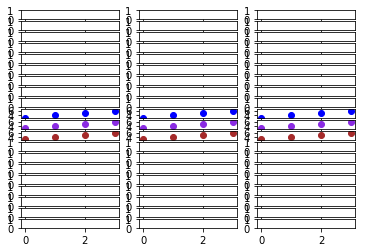

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplot
from matplotlib.figure import Figure 
#from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors as mcolors
import colorsys
import seaborn as sbn

colorlist = [ name for name, color in mcolors.cnames.items()]
def col(color, amount):
    c = mcolors.cnames[color]
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    if amount > 0:
        return colorsys.hls_to_rgb(c[0], .7, c[2])  
    elif amount == 0:
        return colorsys.hls_to_rgb(c[0], .5, c[2])
    else:
        return colorsys.hls_to_rgb(c[0], .3, c[2])
            
fig, ax = mplot.subplots(nrows=20, ncols=3, sharex=True)
for i in range(9,12):
    for j in range(3):
        color = colorlist[i]#col(colorlist[i], j-1)
        ax[i,j].errorbar(x=[0,1,2,3], y=[3,4,5,6], yerr=[.1,.2,.4,.5], 
                   color=color, barsabove=True, fmt='o', capthick=10)
mplot.show()
    